# Demonstration of soScope working on Multiomics

This is a demonstration of soScope analysis on simulated data with multiomics data (Poisson and negative binomial distribution).

Bohan Li @ Deng ai Lab @ BUAA 2023.

Software provided as is under MIT License.

## Install dependency software
To run this demo, use `pip install scanpy` to install scanpy

In [11]:
import os
import sys
import torch
import random

sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from soScope_model.train import two_step_train
from soScope_model.inference import infer

def seed_all(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    
seed_all(0)

## Scene Preset

Experiment: Human skin tissue multiomics resolution enhancement experiment.

Inputs: 1,618 “low-resolution” spots with protien and gene expressions (X), morphological image features generated from a pretrained Inception-v3 model at high-resolution (Y), and spatial neighboring relations (A)

Outputs: Profiles of 6,472 “enhanced-resolution” spots.

Genes analyzed : FADS1 in Pilosebaceous region 1, RNA18S5 in Pilosebaceous region 2, TMEM132D in Dermis.

Proteins analyzed : CD98 in Pilosebaceous region 1, GPR56 in Pilosebaceous region 2, IgM in Dermis.

In [2]:
# Train model
# vgae_experiment_dir: saving directory for pre-training stage.
# soScope_experiment_dir: saving directory soScope training.
# data_dir: dataset directory contains necessary data mentioned above.
# vgae_config_file: model configuration for variational graph auto-encoder used in pre-training stage.
# soScope_config_file: model configuration for soScope.
# device, checkpoint_every, backup_every, epochs: default training settings.
# num_neighbors: edges are built between every neighboring 4 nodes, not to be revised.
two_step_train(logging=not None,
               vgae_experiment_dir='experiments/VGAE_multiomics_all',
               soScope_experiment_dir='experiments/soScope_multiomics_all',
               data_dir='DataSet/Multiomics_demo_all/',
               vgae_config_file='config/Multiomics_all/VGAE.yml',
               soScope_config_file='config/Multiomics_all/soScope.yml',
               device='cuda',
               checkpoint_every=1000,
               backup_every=200,
               epochs=[8000, 8000],
               num_neighbors=4)


Step 1
<class 'soScope_model.training.vgae.VGAETrainer_Joint_PNB'>
===There are 1618 nodes to train.===
Sub Data Loaded
We built edges between every neighboring 4 nodes
Spatial Data Loaded
Dataset loaded!
========== Initialization the graph encoder ============


100%|██████████| 8000/8000 [01:46<00:00, 75.13it/s]


Step 2
<class 'soScope_model.training.svae_Global_Joint.soScope_Joint'>
Pretrained Model Loaded!
========== Optimization of soScope ============


100%|██████████| 8000/8000 [31:25<00:00,  4.24it/s]


In [3]:
# Inference enhanced expression
# experiment_dir: saving directory for inference stage.
# non_negative, device: default training settings.
# num_neighbors: edges are built between every neighboring 4 nodes, not to be revised.
# data_dir: dataset directory contains necessary data mentioned above.
# result_dir: saving directory for results.
infer(
        experiment_dir= 'experiments/soScope_multiomics_all',
        non_negative=True,
        num_neighbors=4,
        data_dir= 'DataSet/Multiomics_demo_all/',
        result_dir='DataSet/Multiomics_demo_all/',
        device='cuda')

<class 'soScope_model.training.svae_Global_Joint.soScope_Joint'>
Pretrained Model Loaded!
We built edges between every neighboring 4 nodes
Spatial Data Loaded


In [12]:
# Visualization

# Load results from dist
# lr_count, position: merged data with positions contains column (x) and row (y) index.
# original_count, en_position: enhanced data with positions contains column (en_x) and row (en_y) index.
# hr_count: soScope data.

lr_count = np.load(f'DataSet/Multiomics_demo_all/label.npy')
position = pd.read_csv(f'DataSet/Multiomics_demo_all/position_with_center.csv')
y = (-position['col']).tolist()
x = position['row'].tolist()

en_position = pd.read_csv(f'DataSet/Multiomics_demo_all/position_enhance_with_center.csv')
en_y = (-en_position['col']).tolist()
en_x = en_position['row'].tolist()

hr_count = np.load(f'DataSet/Multiomics_demo_all/infer_subspot.npy')

In [13]:
feature_names = pd.read_csv(f'DataSet/Multiomics_demo_all/rowData.csv')['Features'].tolist()

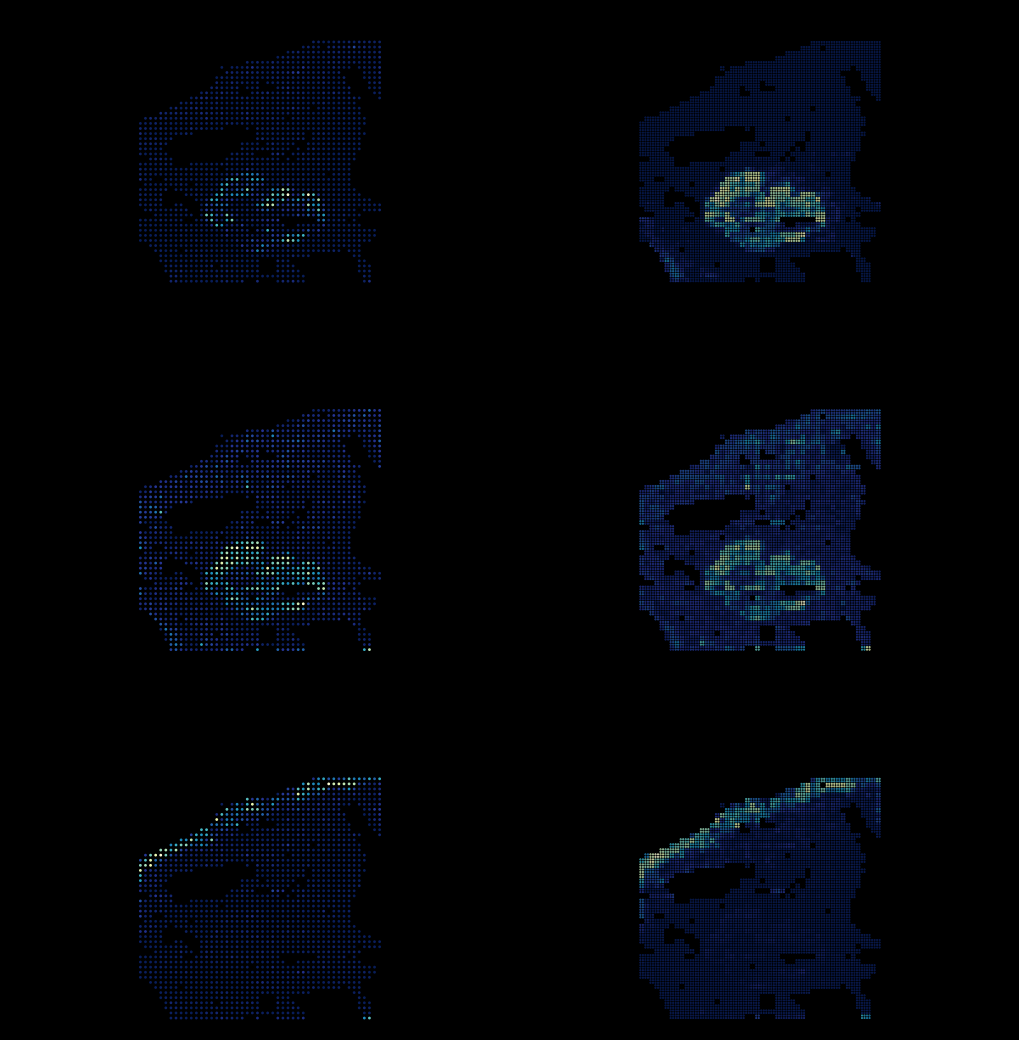

In [16]:
# Simulated resolution enhancement visualization. 
# Visualized data: proteins: HLA, CD71, CD235, and CD146; genes: TMEM132D, CPNE5, RNA18S5, and NMNAT1.
# arrangment in subplot: orginal data (left) at low resolution and scScope (right) predicted data at enhanced resolution

protein_roi = ['CD71.CCGTGTTCCTCATTA','CD107a..LAMP.1..CAGCCCACTGCAATA',
            'IgM.TAGCGAGCCCGTATA', ]
protein_names = ['CD98', 'GPR56', 'IgM']
protein_idx_list = [feature_names.index(p) for p in protein_roi]
cmap = 'YlGnBu_r'
fig = plt.figure(figsize=(10, 10), dpi=100)
fig.set_facecolor('black')
count = 0
for idx in protein_idx_list:
    # merged data visualization
#     gene_name = gene_names[idx]
    protein_name = protein_names[count]
    ax = fig.add_subplot(3, 2, 2*count+1)
    plt.axis("equal")
    plt.axis('off')
    plt.scatter(x, y, s=1,
                marker = 'o',
                c=lr_count[:, idx],
                cmap=cmap
                )
    plt.title(protein_name + '_Original', y=1)
    
    # soScope predicted data visualization
    ax = fig.add_subplot(3, 2, 2*count+2)
    plt.axis("equal")
    plt.axis('off')
    plt.scatter(en_x, en_y, s=0.2,
                marker='o',
                c=hr_count[:, idx],
                cmap=cmap
                )
    plt.title(protein_name + '_soScope', y=1)
    count += 1
    
fig.subplots_adjust(left=0,right=1,top=1,bottom=0,
                    wspace=0,hspace=0.4)
plt.show()

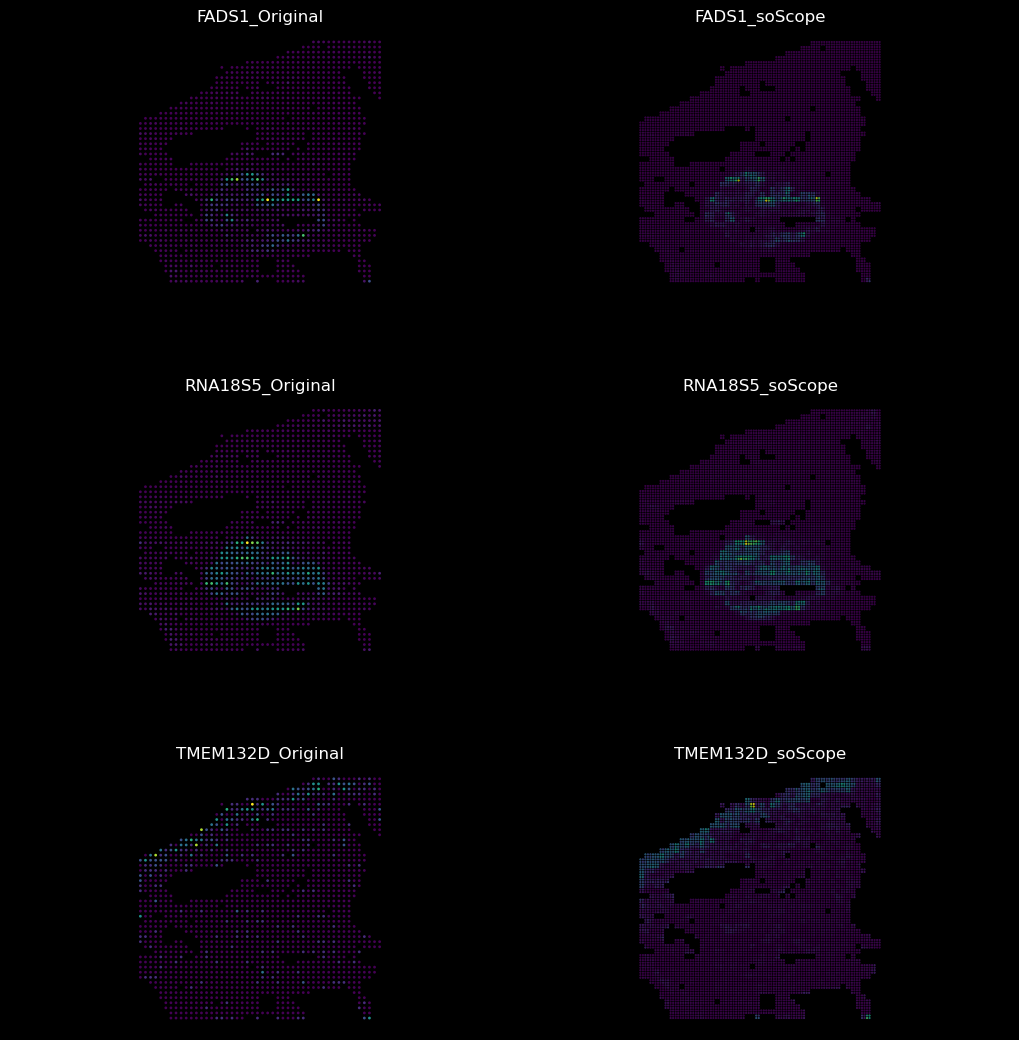

In [15]:
gene_roi = ['FADS1', 'RNA18S5', 'TMEM132D']
gene_idx_list = [feature_names.index(g) for g in gene_roi]

cmap = 'viridis'
fig = plt.figure(figsize=(10, 10), dpi=100)
fig.set_facecolor('black')
count = 0
for idx in gene_idx_list:
    # merged data visualization
#     gene_name = gene_names[idx]
    gene = gene_roi[count]
    ax = fig.add_subplot(3, 2, 2*count+1)
    plt.axis("equal")
    plt.axis('off')
    plt.scatter(x, y, s=1,
                marker = 'o',
                c=lr_count[:, idx],
                cmap=cmap
                )
    plt.title(gene+'_Original', y=1, color='w')
    
    # soScope predicted data visualization
    ax = fig.add_subplot(3, 2, 2*count+2)
    plt.axis("equal")
    plt.axis('off')
    plt.scatter(en_x, en_y, s=0.2,
                marker='o',
                c=hr_count[:, idx],
                cmap=cmap
                )
    plt.title(gene+'_soScope', y=1, color='w')
    count += 1
    
fig.subplots_adjust(left=0,right=1,top=1,bottom=0,
                    wspace=0,hspace=0.4)
plt.show()

In [17]:
# Import required libraries
import scanpy as sc
from anndata import AnnData

def SCTransform(array):
    adata = AnnData(array)

    # Preprocess the AnnData object
    sc.pp.normalize_total(adata, target_sum=1e4)  # Normalize the data
    sc.pp.log1p(adata)  # Log-transform the data
    sc.pp.highly_variable_genes(adata, n_top_genes=50)  # Identify highly variable genes

    # Perform SCTransform
    sc.pp.scale(adata, max_value=10)  # Scale the data
    return adata.X

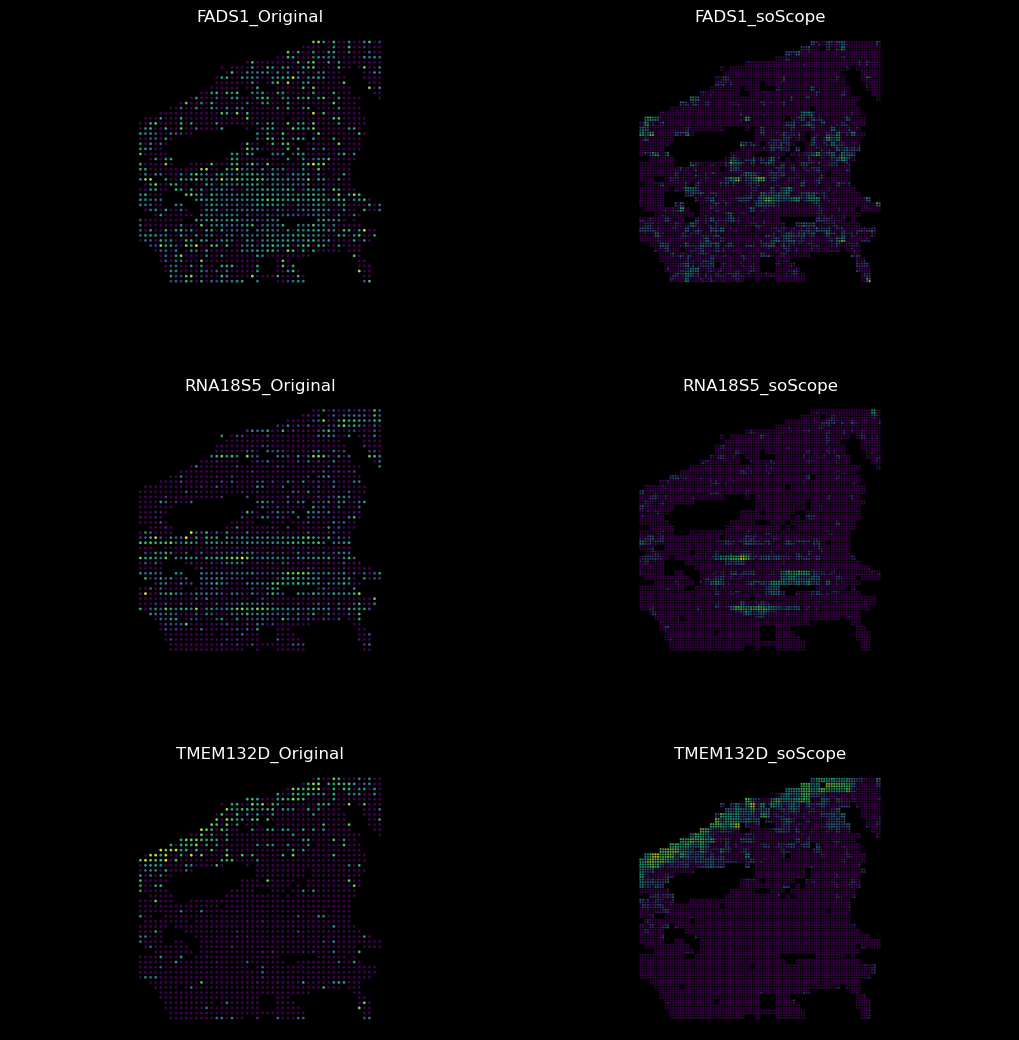

In [18]:
lr_gene_sct = SCTransform(lr_count[:,283:])
hr_gene_sct = SCTransform(np.nan_to_num(hr_count[:,283:]))

gene_roi = ['FADS1', 'RNA18S5', 'TMEM132D']
gene_idx_list = [feature_names.index(g) for g in gene_roi]

cmap = 'viridis'
fig = plt.figure(figsize=(10, 10), dpi=100)
fig.set_facecolor('black')
count = 0
for idx in gene_idx_list:
    # merged data visualization
#     gene_name = gene_names[idx]
    gene = gene_roi[count]
    ax = fig.add_subplot(3, 2, 2*count+1)
    plt.axis("equal")
    plt.axis('off')
    plt.scatter(x, y, s=1,
                marker = 'o',
                c=lr_gene_sct[:, idx-283],
                cmap=cmap, vmin=0.2*(np.max(lr_gene_sct[:,idx-283])), vmax=np.max(lr_gene_sct[:,idx-283])
                )
    plt.title(gene+'_Original', y=1, color='w')
    
    # soScope predicted data visualization
    ax = fig.add_subplot(3, 2, 2*count+2)
    plt.axis("equal")
    plt.axis('off')
    plt.scatter(en_x, en_y, s=0.2,
                marker='o',
                c=hr_gene_sct[:, idx-283],
                cmap=cmap, vmin=0.2*(np.max(hr_gene_sct[:,idx-283])), vmax=np.max(hr_gene_sct[:,idx-283])
                )
    plt.title(gene+'_soScope', y=1, color='w')
    count += 1
    
fig.subplots_adjust(left=0,right=1,top=1,bottom=0,
                    wspace=0,hspace=0.4)
plt.show()

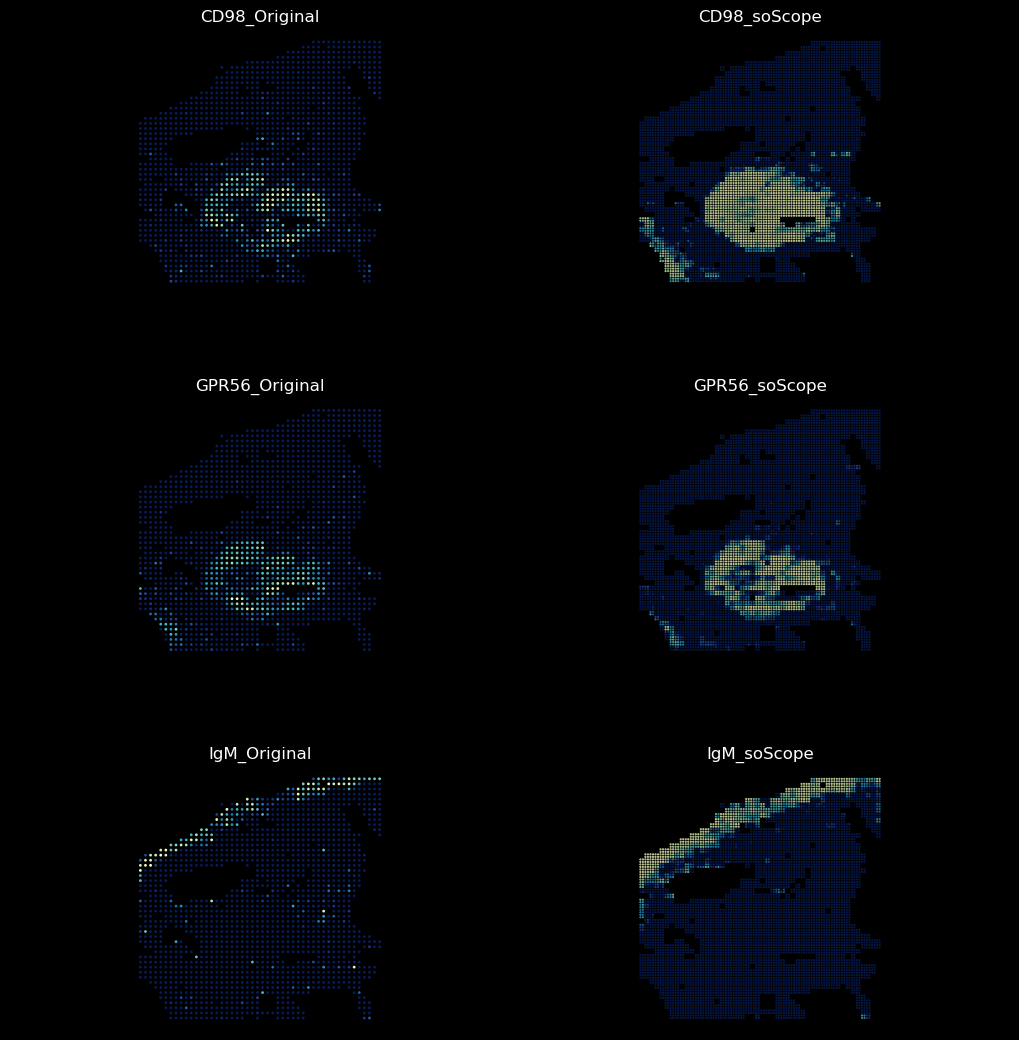

In [19]:
lr_protein_sct = SCTransform(lr_count[:,:283])
hr_protein_sct = SCTransform(np.nan_to_num(hr_count[:,:283]))

protein_roi = ['CD71.CCGTGTTCCTCATTA','CD107a..LAMP.1..CAGCCCACTGCAATA',
            'IgM.TAGCGAGCCCGTATA', ]
protein_names = ['CD98', 'GPR56', 'IgM']
protein_idx_list = [feature_names.index(p) for p in protein_roi]
cmap = 'YlGnBu_r'
fig = plt.figure(figsize=(10, 10), dpi=100)
fig.set_facecolor('black')
count = 0
for idx in protein_idx_list:
    # merged data visualization
#     gene_name = gene_names[idx]
    protein_name = protein_names[count]
    ax = fig.add_subplot(3, 2, 2*count+1)
    plt.axis("equal")
    plt.axis('off')
    plt.scatter(x, y, s=1,
                marker = 'o',
                c=lr_protein_sct[:, idx],
                cmap=cmap, vmin=0.3*np.max(hr_protein_sct[:,idx])
                )
    plt.title(protein_name + '_Original', y=1, color='w')
    
    # soScope predicted data visualization
    ax = fig.add_subplot(3, 2, 2*count+2)
    plt.axis("equal")
    plt.axis('off')
    plt.scatter(en_x, en_y, s=0.2,
                marker='o',
                c=hr_protein_sct[:, idx],
                cmap=cmap, vmin=0.3*np.max(hr_protein_sct[:,idx])
                )
    plt.title(protein_name + '_soScope', y=1, color='w')
    count += 1
    
fig.subplots_adjust(left=0,right=1,top=1,bottom=0,
                    wspace=0,hspace=0.4)
plt.show()